# 大問2

## 計算環境
MacBook Pro (13-inch, 2016, Two Thunderbolt 3 ports)

プロセッサ: 2 GHz Intel Core i5

メモリ: 8 GB 1867 MHz LPDDR3

ソフト: Jupyter notebook (5.4.0)

言語: Python 3.6.4

## (1)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

### 問題設定

Aは1500次とした。

bは1500次で各値は0から100までのfloat型の乱数を作成した。

乱数はseedをとって各手法で固定し、各手法とも反復回数は最大で1500回とした。

また、許容誤差は1 x 10^-10とした

In [2]:
# 次数の設定
degree = 1500

# 反復回数の設定
n_iteration = 1500

# 許容誤差
allowable_error = 1e-10

In [3]:
# A: 本レポートではtridiagonal_matrix(2), tridiagonal_matrix(20)を用いる
def tridiagonal_matrix(c, n = degree):
    A = np.zeros([n, n])
    for i in range(n):
        if i == 0:
            A[i,i] = c 
            A[i, i+1] = -1
        elif i == n - 1:
            A[i, i - 1] = -1
            A[i, i] = c
        else:
            A[i, i - 1] = -1
            A[i, i] = c
            A[i, i + 1] = -1
    return A

# b
def constant_vector(n = degree):
    np.random.seed(23)  # 23は適当な数字
    return np.random.uniform(0.0, 100.0, [n, 1])

### 実装

逆行列は一度求めればその後掛け算するだけで使えるため、計算してしまっています

#### Jacobi法

In [4]:
def jacobi(A, b = constant_vector(), x_0 = np.ones([degree, 1]), n_itr = n_iteration):
    xs = np.array([x_0])
    D = np.diag(np.diag(A))
    LU = A - D
    D_inv = np.linalg.inv(D)
    constant_params = [-1 * D_inv @ LU, D_inv @ b]
    for k in range(n_itr):
        if np.linalg.norm(A @ xs[k] - b) < allowable_error:
            print("Jacobi法はk={}で収束しました。".format(k))
            return xs
        xs = np.append(xs, [constant_params[0] @ xs[k] + constant_params[1]], axis = 0)
    print("Jacobi法は反復回数{}回以内では収束しませんでした。".format(n_itr))
    return xs

#### Gauss-Seidel法

In [5]:
def gs(A, b = constant_vector(), x_0 = np.ones([degree, 1]), n_itr = n_iteration):
    xs = np.array([x_0])
    LD_inv = np.linalg.inv(np.tril(A))
    U = np.triu(A, 1)
    constant_params = [-1 * LD_inv @ U, LD_inv @ b]
    for k in range(n_itr):
        if np.linalg.norm(A @ xs[k] - b) < allowable_error:
            print("Gauss-Seidel法はk={}で収束しました。".format(k))
            return xs
        xs = np.append(xs, [constant_params[0] @ xs[k] + constant_params[1]], axis = 0)
    print("Gauss-Seidel法は反復回数{}回以内では収束しませんでした。".format(n_itr))
    return xs

#### SOR法

In [6]:
def sor(A, b = constant_vector(), x_0 = np.ones([degree, 1]), omega = 1.2, n_itr = n_iteration):
    xs = np.array([x_0])
    U = np.triu(A, 1)
    L = np.tril(A, 1)
    D = np.diag(np.diag(A))
    constant_params = [np.linalg.inv(D + omega * L) @ ((1 - omega) * D - omega * U), omega * np.linalg.inv(D + omega * U) @ b]
    for k in range(n_itr):
        if np.linalg.norm(A @ xs[k] - b) < allowable_error:
            print("SOR法はk={}で収束しました。".format(k))
            return xs
        xs = np.append(xs, [constant_params[0] @ xs[k] + constant_params[1]], axis = 0)
    print("SOR法は反復回数{}回以内では収束しませんでした。".format(n_itr))
    return xs

#### CG法

In [7]:
def cg(A, b = constant_vector(), x_0 = np.ones([degree, 1]), n_itr = n_iteration):
    xs = np.array([x_0])
    r = b - A @ xs[0]
    p = r
    for k in range(n_itr):
        if np.linalg.norm(A @ xs[k] - b) < allowable_error:
            print("CG法はk={}で収束しました。".format(k))
            return xs
        alpha = (r.T @ p) / (p.T @ A @ p)
        xs = np.append(xs, [xs[k] + alpha * p], axis = 0)
        r = r - alpha * A @ p
        beta = -1 * (r.T @ A @ p) / (p.T @ A @ p)
        p = r + beta * p
    print("CG法は反復回数{}回以内では収束しませんでした。".format(n_itr))
    return xs

### 検証

In [8]:
def plot_errors(c):
    A = tridiagonal_matrix(c)
    
    error = lambda x: np.linalg.norm(A @ x - constant_vector())

    jacobi_error_transition = list(map(error, jacobi(A)))
    gs_error_transition = list(map(error, gs(A)))
    sor_error_transition = list(map(error, sor(A)))
    cg_error_transition = list(map(error, cg(A)))

    plt.plot(np.arange(len(jacobi_error_transition)), jacobi_error_transition, label='Jacobi法')
    plt.plot(np.arange(len(gs_error_transition)), gs_error_transition, label='Gauss-Seidel法')
    plt.plot(np.arange(len(sor_error_transition)), sor_error_transition, label='SOR法')
    plt.plot(np.arange(len(cg_error_transition)), cg_error_transition, label='CG法')

    plt.legend()
    plt.title("||Ax = b||の推移, c = {}(cond(A) = {})の時".format(c, np.linalg.cond(A)))
    plt.xlabel('反復回数 (k)')
    plt.ylabel('||Ax_k - b||')
    plt.grid()
    plt.show()

まずはc = 2とc = 20の時で誤差ノルムの推移を比較する

c = 2 の時

Jacobi法は反復回数1500回以内では収束しませんでした。
Gauss-Seidel法は反復回数1500回以内では収束しませんでした。
SOR法は反復回数1500回以内では収束しませんでした。
CG法は反復回数1500回以内では収束しませんでした。


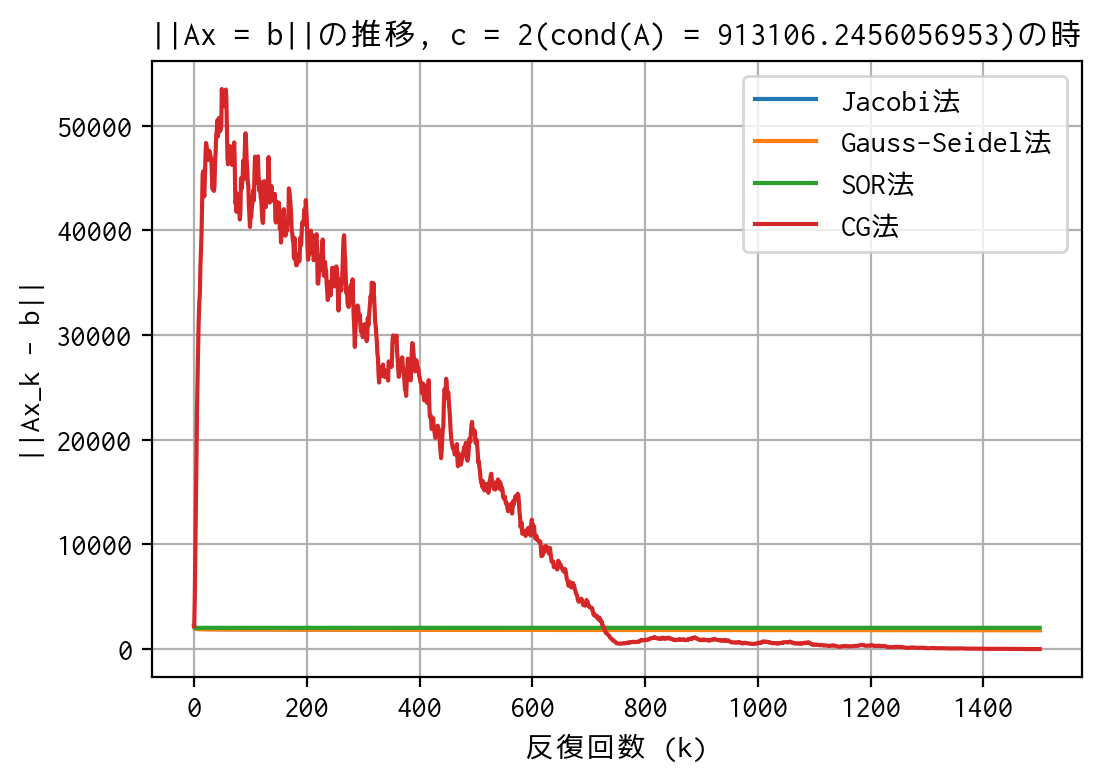

In [9]:
plot_errors(2)

c ＝ 20 の時

Jacobi法はk=14で収束しました。
Gauss-Seidel法はk=11で収束しました。
SOR法は反復回数1500回以内では収束しませんでした。
CG法はk=11で収束しました。


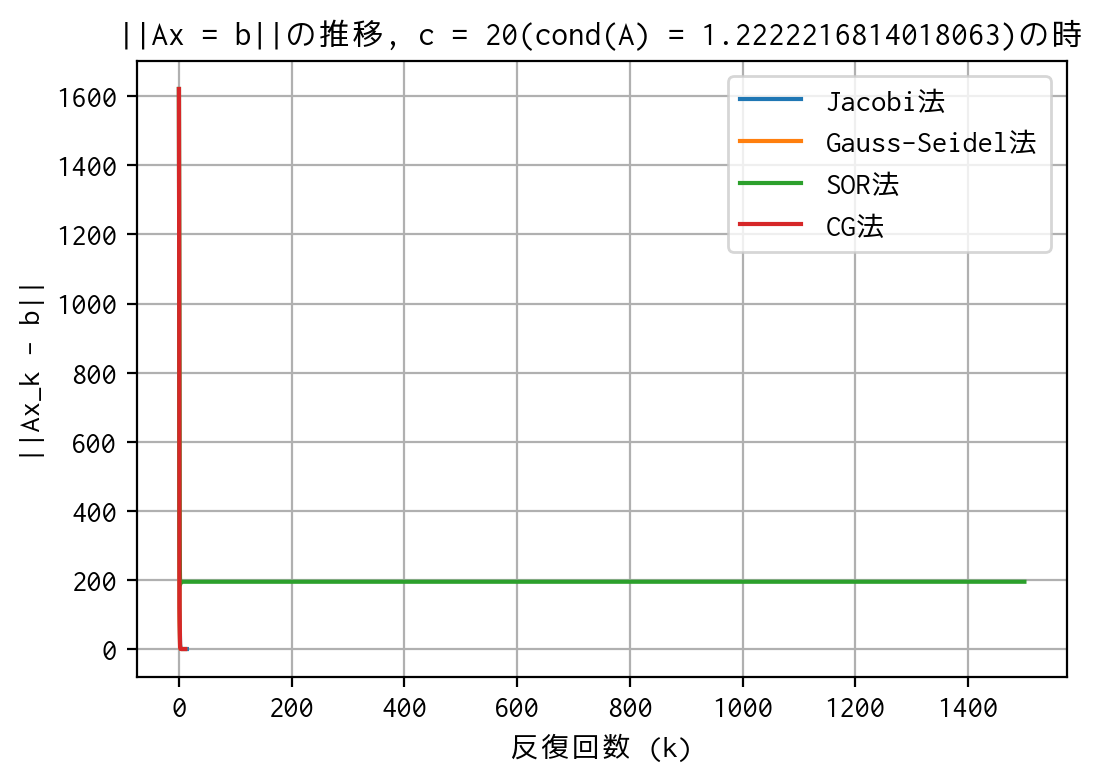

In [10]:
plot_errors(20)

0付近でわかりにくいので、次に、誤差ノルムの常用対数をとる

In [11]:
def plot_errors_by_log(c):
    A = tridiagonal_matrix(c)
    
    error = lambda x: np.log10(np.linalg.norm(A @ x - constant_vector()))

    jacobi_error_transition = list(map(error, jacobi(A)))
    gs_error_transition = list(map(error, gs(A)))
    sor_error_transition = list(map(error, sor(A)))
    cg_error_transition = list(map(error, cg(A)))

    plt.plot(np.arange(len(jacobi_error_transition)), jacobi_error_transition, label='Jacobi法')
    plt.plot(np.arange(len(gs_error_transition)), gs_error_transition, label='Gauss-Seidel法')
    plt.plot(np.arange(len(sor_error_transition)), sor_error_transition, label='SOR法')
    plt.plot(np.arange(len(cg_error_transition)), cg_error_transition, label='CG法')
    
    plt.legend()
    plt.title("log_10||Ax = b||の推移, c = {}(cond(A) = {})の時".format(c, np.linalg.cond(A)))
    plt.xlabel('反復回数 (k)')
    plt.ylabel('log_10(||Ax_k - b||)')
    plt.grid()
    plt.show()

c = 2 の時

Jacobi法は反復回数1500回以内では収束しませんでした。
Gauss-Seidel法は反復回数1500回以内では収束しませんでした。
SOR法は反復回数1500回以内では収束しませんでした。
CG法は反復回数1500回以内では収束しませんでした。


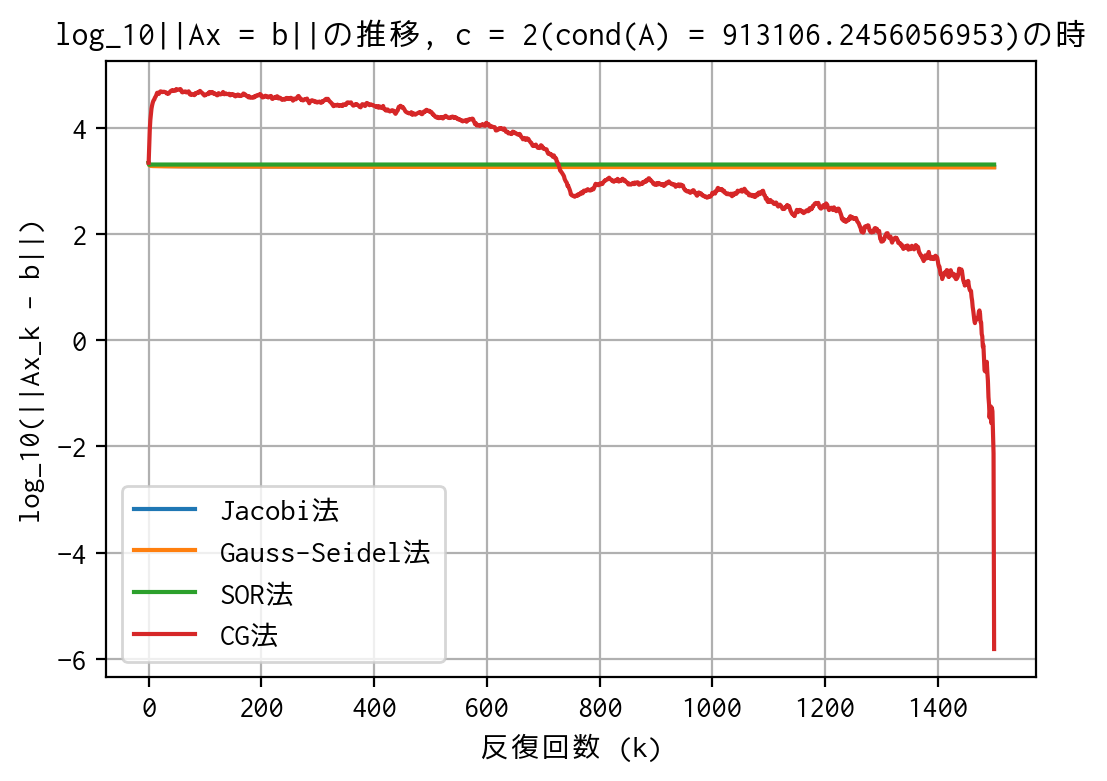

In [12]:
plot_errors_by_log(2)

c = 20 の時

Jacobi法はk=14で収束しました。
Gauss-Seidel法はk=11で収束しました。
SOR法は反復回数1500回以内では収束しませんでした。
CG法はk=11で収束しました。


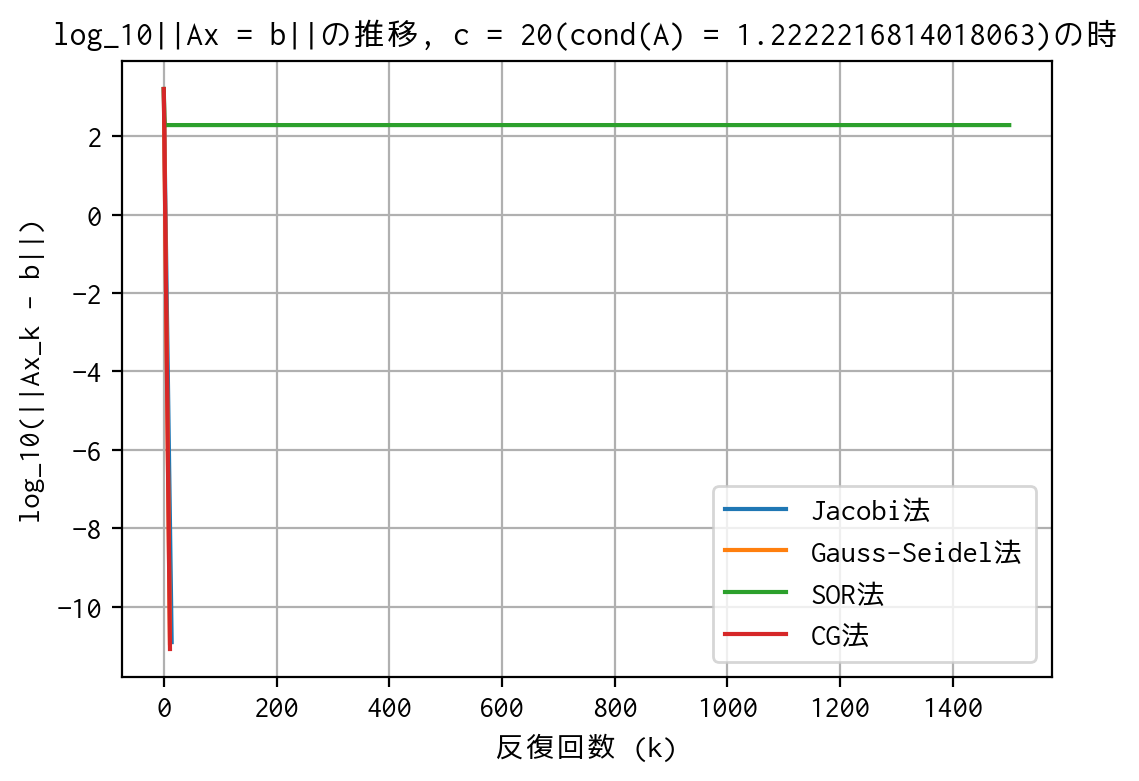

In [13]:
plot_errors_by_log(20)

c = 2 の時もCG法では収束しそうなので、もう少し見てみる

CG法は反復回数5000回以内では収束しませんでした。


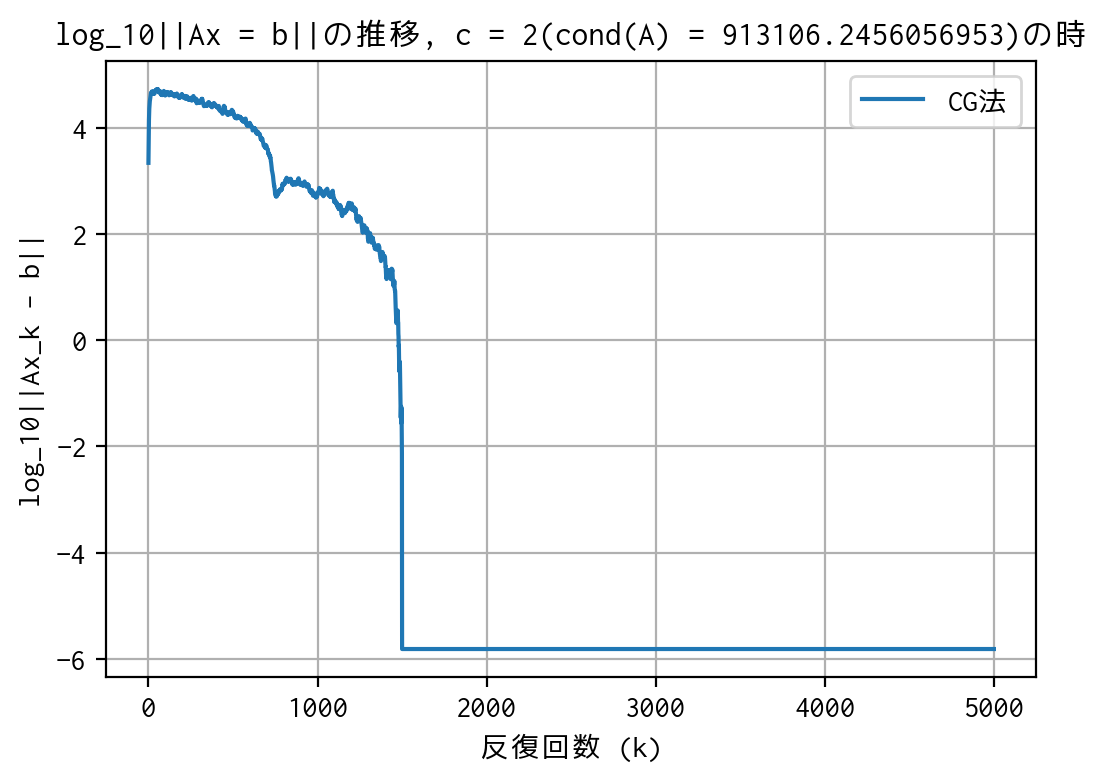

In [16]:
A = tridiagonal_matrix(2)

error = lambda x: np.log10(np.linalg.norm(A @ x - constant_vector()))

cg_error_transition = list(map(error, cg(A, n_itr=5000))) # n_itrを大きくした。

plt.plot(np.arange(len(cg_error_transition)), cg_error_transition, label='CG法')

plt.legend()
plt.title("log_10||Ax = b||の推移, c = {}(cond(A) = {})の時".format(c, np.linalg.cond(A)))
plt.xlabel('反復回数 (k)')
plt.ylabel('log_10||Ax_k - b||')
plt.grid()
plt.show()

In [17]:
cg_error_transition[-1]

-5.815832217056463

誤差は10^-5.8乗程度で固まってしまった。

## (2) 考察

#### c = 2 と c = 20 での違い

In [14]:
print("c = 2の時の条件数: ", np.linalg.cond(tridiagonal_matrix(2)))
print("c = 20の時の条件数: ", np.linalg.cond(tridiagonal_matrix(20)))

c = 2の時の条件数:  913106.2456056953
c = 20の時の条件数:  1.2222216814018063


c = 20ではどの手法でも急速に||Ax - b||が0に近づいているのに対し、c = 2で||Ax - b||が1000回の反復で0に収束していっているように見えるのは、CG法以外であった。

上のように、c = 2 と c = 20 とで条件数が大きく異なるが、この現象はこの条件数の差が大きく影響を及ぼしていると考えられる。

#### 各手法の比較

CG法以外の定常反復法ではほぼ一様に||Ax-b||の値が0に近づいているように見える。

一方、CG方では、反復回数が小さい時に誤差が急激に大きくなるが、c = 2でもc = 20でも、反復を500回程度繰り返したあたりから急速に収束に向かい、1000回程度反復したあとは他の手法に比べ、誤差が非常に小さくなっている。